In [1]:
!pip install dipy

In [2]:
import numpy as np
from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
from dipy.align.imwarp import DiffeomorphicMap
from dipy.align.metrics import CCMetric
from dipy.core.gradients import gradient_table
from dipy.data import get_fnames
from dipy.io.image import load_nifti, save_nifti
from dipy.io.gradients import read_bvals_bvecs
import os.path
from dipy.viz import regtools

C:\Users\pha\anaconda3\envs\bvenv\lib\site-packages\dipy\viz\__init__.py:31: UserWarning: You do not have FURY installed. Some visualization functions might not work for you. For installation instructions, please visit: https://fury.gl/
  warnings.warn(


In [12]:
from dipy.segment.mask import median_otsu
stanford_b0_masked, stanford_b0_mask = median_otsu(stanford_b0,
                                                   median_radius=4,
                                                   numpass=4)
syn_b0_masked, syn_b0_mask = median_otsu(syn_b0, median_radius=4, numpass=4)

static = stanford_b0_masked
static_affine = stanford_b0_affine
moving = syn_b0_masked
moving_affine = syn_b0_affine

ValueError: threshold_otsu is expected to work with images having more than one color. The input image seems to have just one color 0.

In [24]:
from glob import glob

data_files = glob('../../brainmask_nii/*.nii')
data_files.sort()

i = 1

ixi_idx = 0
oas1_idx = 314
oas3_idx = 800

ixi = data_files[ixi_idx+i]
oas1 = data_files[oas1_idx+i]
oas3 = data_files[oas3_idx+i]

In [27]:
stanford_b0, stanford_b0_affine = load_nifti(ixi)
stanford_b0 = np.squeeze(stanford_b0)[..., 0]

### bic-berkeley.github.io
https://bic-berkeley.github.io/psych-214-fall-2016/dipy_registration.html

In [35]:
# Set up our usual routines and configuration
import os
import numpy as np
np.set_printoptions(precision=4, suppress=True)
import matplotlib.pyplot as plt
# - set gray colormap and nearest neighbor interpolation by default
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'
import nibabel as nib

In [36]:
from dipy.viz import regtools
from dipy.align.imaffine import (AffineMap,
                                 MutualInformationMetric,
                                 AffineRegistration)
from dipy.align.transforms import (TranslationTransform3D,
                                   RigidTransform3D,
                                   AffineTransform3D)

In [37]:
>>> moving_img = nib.load(ixi)
>>> template_img = nib.load(oas1)

In [40]:
>>> moving_data = moving_img.get_fdata()
>>> moving_affine = moving_img.affine
>>> template_data = template_img.get_fdata()
>>> template_affine = template_img.affine

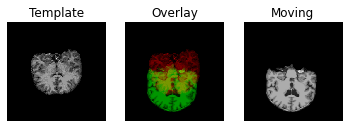

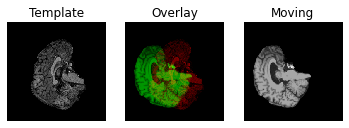

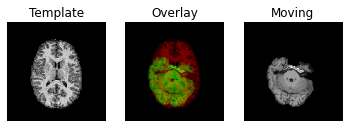

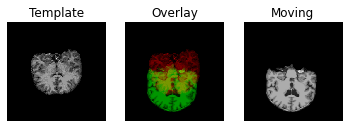

In [42]:
>>> identity = np.eye(4)
>>> affine_map = AffineMap(identity,
...                        template_data.shape, template_affine,
...                        moving_data.shape, moving_affine)
>>> resampled = affine_map.transform(moving_data)
>>> regtools.overlay_slices(template_data, resampled, None, 0,
...                         "Template", "Moving")
>>> regtools.overlay_slices(template_data, resampled, None, 1,
...                         "Template", "Moving")
>>> regtools.overlay_slices(template_data, resampled, None, 2,
...                         "Template", "Moving")

In [43]:
# The mismatch metric
nbins = 32
sampling_prop = None
metric = MutualInformationMetric(nbins, sampling_prop)

In [44]:
# The optimization strategy
level_iters = [10, 10, 5]
sigmas = [3.0, 1.0, 0.0]
factors = [4, 2, 1]

In [45]:
affreg = AffineRegistration(metric=metric,
                            level_iters=level_iters,
                            sigmas=sigmas,
                            factors=factors)

In [46]:
transform = TranslationTransform3D()
params0 = None
translation = affreg.optimize(template_data, moving_data, transform, params0,
                              template_affine, moving_affine)

Optimizing level 2 [max iter: 10]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 5]


In [47]:
translation.affine

array([[ 1.    ,  0.    ,  0.    ,  5.5288],
       [ 0.    ,  1.    ,  0.    ,  3.6529],
       [ 0.    ,  0.    ,  1.    , 38.8881],
       [ 0.    ,  0.    ,  0.    ,  1.    ]])

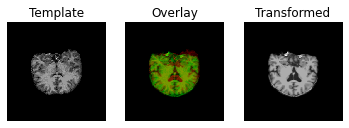

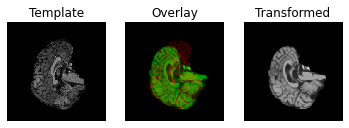

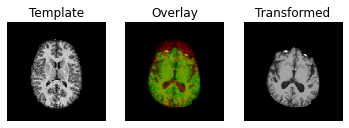

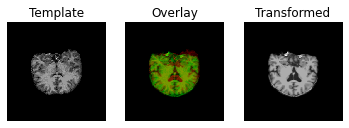

In [48]:
transformed = translation.transform(moving_data)
regtools.overlay_slices(template_data, transformed, None, 0,
                        "Template", "Transformed")
regtools.overlay_slices(template_data, transformed, None, 1,
                        "Template", "Transformed")
regtools.overlay_slices(template_data, transformed, None, 2,
                        "Template", "Transformed")

In [49]:
transform = RigidTransform3D()
rigid = affreg.optimize(template_data, moving_data, transform, params0,
                        template_affine, moving_affine,
                        starting_affine=translation.affine)

Optimizing level 2 [max iter: 10]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 5]


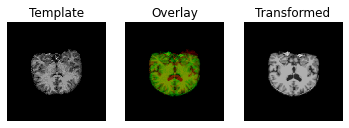

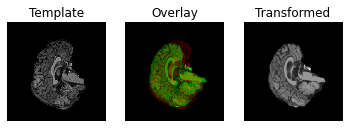

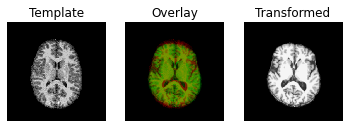

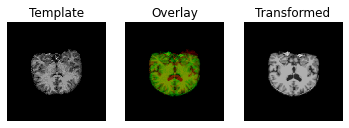

In [50]:
>>> transformed = rigid.transform(moving_data)
>>> regtools.overlay_slices(template_data, transformed, None, 0,
...                         "Template", "Transformed")
>>> regtools.overlay_slices(template_data, transformed, None, 1,
...                         "Template", "Transformed")
>>> regtools.overlay_slices(template_data, transformed, None, 2,
...                         "Template", "Transformed")

In [51]:
transform = AffineTransform3D()
# Bump up the iterations to get an more exact fit
affreg.level_iters = [1000, 1000, 100]
affine = affreg.optimize(template_data, moving_data, transform, params0,
                         template_affine, moving_affine,
                         starting_affine=rigid.affine)

Optimizing level 2 [max iter: 1000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


In [52]:
>>> affine.affine

array([[ 0.9979, -0.0707,  0.1164,  5.9566],
       [ 0.1482,  0.8337, -0.2548, -6.2717],
       [-0.1187,  0.3297,  0.9083, 44.7975],
       [ 0.    ,  0.    ,  0.    ,  1.    ]])

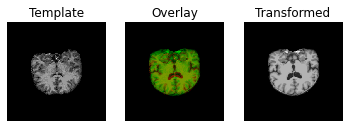

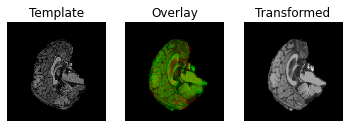

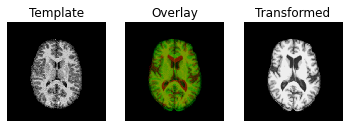

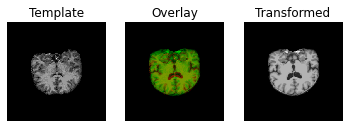

In [53]:
>>> transformed = affine.transform(moving_data)
>>> regtools.overlay_slices(template_data, transformed, None, 0,
...                         "Template", "Transformed")
>>> regtools.overlay_slices(template_data, transformed, None, 1,
...                         "Template", "Transformed")
>>> regtools.overlay_slices(template_data, transformed, None, 2,
...                         "Template", "Transformed")

In [54]:
from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
from dipy.align.imwarp import DiffeomorphicMap
from dipy.align.metrics import CCMetric

In [55]:
# The mismatch metric
metric = CCMetric(3)
# The optimization strategy:
level_iters = [10, 10, 5]
# Registration object
sdr = SymmetricDiffeomorphicRegistration(metric, level_iters)

In [56]:
mapping = sdr.optimize(template_data, moving_data, template_affine,
                       moving_affine, affine.affine)

In [57]:
warped_moving = mapping.transform(moving_data)

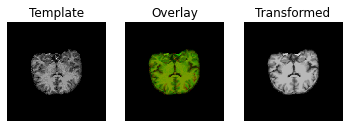

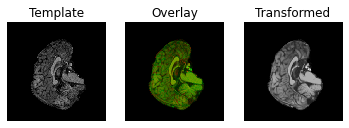

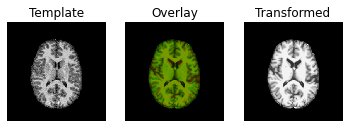

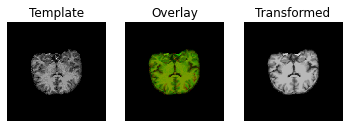

In [59]:
regtools.overlay_slices(template_data, warped_moving, None, 0,
                        "Template", "Transformed")
regtools.overlay_slices(template_data, warped_moving, None, 1,
                        "Template", "Transformed")
regtools.overlay_slices(template_data, warped_moving, None, 2,
                        "Template", "Transformed")

In [2]:
from src.registration import *
from glob import glob

data_files = glob('../../brainmask_nii/*.nii')
data_files.sort()

i = 0

ixi_idx = 0
oas1_idx = 314
oas3_idx = 800

ixi = data_files[ixi_idx+i]
oas1 = data_files[oas1_idx+i]
oas3 = data_files[oas3_idx+i]

C:\Users\pha\anaconda3\envs\bvenv\lib\site-packages\dipy\viz\__init__.py:31: UserWarning: You do not have FURY installed. Some visualization functions might not work for you. For installation instructions, please visit: https://fury.gl/
  warnings.warn(


In [2]:
affreg = Registration(template=ixi, moving=oas1).optimize()

Transformation.
Optimizing level 2 [max iter: 10]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 5]
Rigid.
Optimizing level 2 [max iter: 10]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 5]
Affine.
Optimizing level 2 [max iter: 1000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Symmetricdr.


In [3]:
warped_moving = affreg.transform(nib.load(oas1).get_fdata())

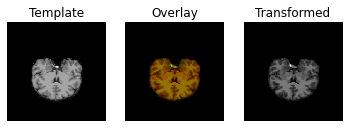

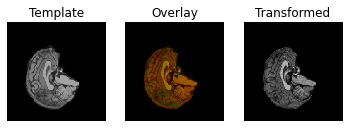

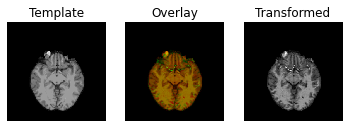

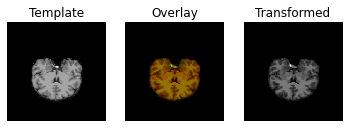

In [6]:
regtools.overlay_slices(nib.load(ixi).get_fdata(), warped_moving, None, 0,
                        "Template", "Transformed")
regtools.overlay_slices(nib.load(ixi).get_fdata(), warped_moving, None, 1,
                        "Template", "Transformed")
regtools.overlay_slices(nib.load(ixi).get_fdata(), warped_moving, None, 2,
                        "Template", "Transformed")

In [5]:
data_files = list(filter(lambda x: x.split('\\')[-1][:3] == 'IXI', glob('../../brainmask_nii/*.nii')))
data_files.sort()
template = data_files.pop(0)

for i, moving in enumerate(data_files):
    print(f"{i:<3}th IXI Brain")
    affreg = Registration(template=template, moving=moving).optimize()
    warped = affreg.transform(nib.load(moving).get_fdata())
    fname = moving.split('\\')[-1].split('.')[0]
    np.save(f'../../brainmask_reg/{fname}_registered.npy')

0  th IXI Brain
Transformation.
Optimizing level 2 [max iter: 10]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 5]


KeyboardInterrupt: 

In [9]:
warped_moving = affreg.transform(nib.load(moving).get_fdata())

In [33]:
np.save('test.npy', warped_moving)

In [34]:
tst = np.load('test.npy')

In [35]:
tst

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [29]:
affreg.affine

AttributeError: 'DiffeomorphicMap' object has no attribute 'affine'

In [30]:
nib.nifti1.Nifti1Image(warped_moving)

TypeError: __init__() missing 1 required positional argument: 'affine'

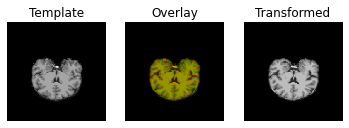

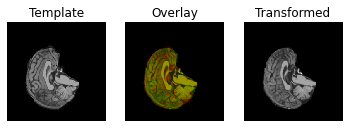

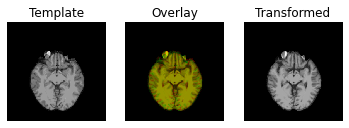

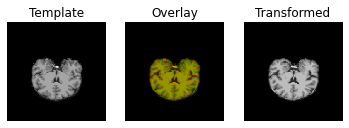

In [10]:
regtools.overlay_slices(nib.load(ixi).get_fdata(), warped_moving, None, 0,
                        "Template", "Transformed")
regtools.overlay_slices(nib.load(ixi).get_fdata(), warped_moving, None, 1,
                        "Template", "Transformed")
regtools.overlay_slices(nib.load(ixi).get_fdata(), warped_moving, None, 2,
                        "Template", "Transformed")

In [13]:
template_data = nib.load(template).get_fdata()
template_affine = nib.load(template).affine

In [11]:
moving_img = nib.load(moving)
moving_data = moving_img.get_data()
moving_affine = moving_img.affine

<ipython-input-11-d162beab9c23>:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  moving_data = moving_img.get_data()


In [17]:
template_affine, moving_affine

(array([[  -1.    ,    0.    ,    0.    ,  129.3599],
        [   0.    ,    0.    ,    1.    , -115.7633],
        [  -0.    ,   -1.    ,    0.    ,  149.7614],
        [   0.    ,    0.    ,    0.    ,    1.    ]]),
 array([[  -1.    ,   -0.    ,    0.    ,  130.108 ],
        [   0.    ,    0.    ,    1.    , -129.979 ],
        [   0.    ,   -1.    ,   -0.    ,  132.2773],
        [   0.    ,    0.    ,    0.    ,    1.    ]]))

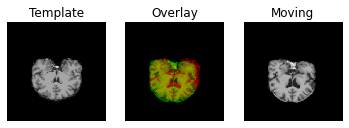

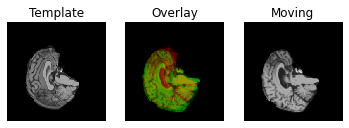

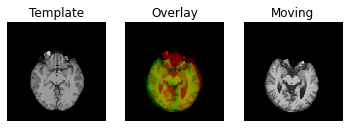

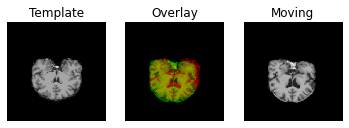

In [14]:
>>> identity = np.eye(4)
>>> affine_map = AffineMap(identity,
...                        template_data.shape, template_affine,
...                        moving_data.shape, moving_affine)
>>> resampled = affine_map.transform(moving_data)
>>> regtools.overlay_slices(template_data, resampled, None, 0,
...                         "Template", "Moving")

>>> regtools.overlay_slices(template_data, resampled, None, 1,
...                         "Template", "Moving")

>>> regtools.overlay_slices(template_data, resampled, None, 2,
...                         "Template", "Moving")

In [57]:
# %load ../2d_slice/src/slice_viewer.py
import matplotlib.pyplot as plt

class SliceViewer:

    def __init__(self, subject):

        self.subject = subject
        self.vertex  = self.subject.shape[0]


    def calculate_ratio(self, subject=None, view='axial'):

        if subject is None:
            subject = self.subject
            vertex = self.vertex

        else:
            vertex = subject.shape[0]

        ratios = []
        for i in range(0, vertex):
    
            slce = self._select_view(view=view, i=i)
            r = int((slce == 0).sum()) / vertex**2
            ratios.append(r)

        return ratios


    def triple_view(self, i=None):

        if i is None:
            i = self.vertex // 2

        saggital = self.subject[i, :, :]
        axial    = self.subject[:, i, :]
        coronal  = self.subject[:, :, i]

        fig, axes = plt.subplots(1, 3)
        for i, s in enumerate([saggital, axial, coronal]):
            axes[i].imshow(s.T, cmap="gray", origin="lower")
        plt.suptitle(f"{i}th Slice view for EPI image")
        plt.show()
        plt.close()


    def single_view(self, i, view='axial'):

        slce = self._select_view(view=view, i=i)

        fig, axes = plt.subplots()
        axes.imshow(slce.T, cmap="gray", origin="lower")
        plt.suptitle(f"{i}th {view.capitalize()} view for EPI image")
        plt.show()
        plt.close()


    def ratio_view(self, view='axial', threshold=.85):

        for i in range(0, self.vertex):
            
            slce = self._select_view(view=view, i=i)
            r = int((slce == 0).sum()) / self.vertex ** 2
            if r < threshold:
                title = f"{view.capitalize()} View for EPI image {i}th slice, {r:.3f} ratio"
                self._show_slice(slce, title)


    def multi_view(self, view='axial', step=5, subject=None):

        if subject is None:
            subject = self.subject
            vertex = self.vertex

        else:
            vertex = subject.shape[0]

        for i in range(0, vertex):
            
            if i % step == 0:
                title = f"{view.capitalize()} View for EPI image {i}th slice"
                self._show_slice(self._select_view(view, i), title=title)


    def _show_slice(self, slce, title=None):

        fig, axes = plt.subplots()
        axes.imshow(slce.T, cmap="gray", origin="lower")
        if title: plt.suptitle(title)
        plt.show()
        plt.close()


    def _select_view(self, view='axial', i=None, subject=None):
        '''
        # X: Saggital View
        # Y: Axial View
        # Z: Coronal View
        '''

        if subject is None:
            subject = self.subject

        if i is None:
            i = self.vertex // 2

        if view == 'saggital' : return subject[i, :, :]
        elif view == 'axial'  : return subject[:, i, :]
        elif view == 'coronal': return subject[:, :, i]
        else: pass

In [21]:
slc = SliceViewer(nib.load(moving).get_fdata())

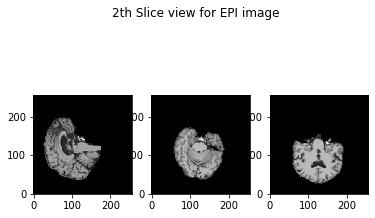

In [22]:
slc.triple_view()

# All Done

In [39]:
from glob import glob

In [40]:
data_files_reg = glob('../../brainmask_reg/*.npy')
data_files_reg.sort()

In [41]:
data_files = glob('../../brainmask_nii/IXI*.nii')
data_files.sort()

In [42]:
data_files_reg[0].split('\\')[-1].split('_')[0]

'IXI002-Guys-0828-T1-brainmask'

In [43]:
data_files[0].split('\\')[-1].split('.')[0]

'IXI002-Guys-0828-T1-brainmask'

In [44]:
reg_set = set(map(lambda x: x.split('\\')[-1].split('_')[0], data_files_reg))
org_set = set(map(lambda x: x.split('\\')[-1].split('.')[0], data_files))

In [45]:
org_set - reg_set

set()

In [38]:
fname = data_files[0].split('\\')[-1].split('.')[0]
np.save(f'../../brainmask_reg/{fname}_registered_template.npy', nib.load(data_files[0]).get_fdata())

In [18]:
np.save()

'../../brainmask_nii\\IXI662-Guys-1120-T1-brainmask.nii'

In [21]:
from src.registration import *
affreg = Registration(template=data_files[0], moving=data_files[-1]).optimize()

C:\Users\pha\anaconda3\envs\bvenv\lib\site-packages\dipy\viz\__init__.py:31: UserWarning: You do not have FURY installed. Some visualization functions might not work for you. For installation instructions, please visit: https://fury.gl/
  warnings.warn(


Transformation.
Optimizing level 2 [max iter: 10]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 5]
Rigid.
Optimizing level 2 [max iter: 10]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 5]
Affine.
Optimizing level 2 [max iter: 1000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Symmetricdr.


In [26]:
warped = affreg.transform(nib.load(data_files[-1]).get_fdata())

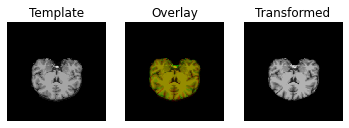

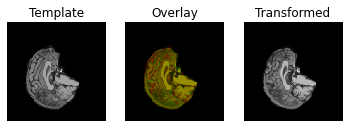

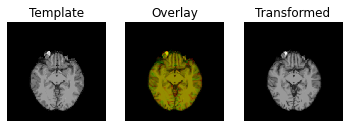

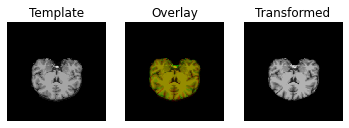

In [28]:
regtools.overlay_slices(nib.load(data_files[0]).get_fdata(), warped, None, 0,
                        "Template", "Transformed")
regtools.overlay_slices(nib.load(data_files[0]).get_fdata(), warped, None, 1,
                        "Template", "Transformed")
regtools.overlay_slices(nib.load(data_files[0]).get_fdata(), warped, None, 2,
                        "Template", "Transformed")

In [30]:
fname = data_files[-1].split('\\')[-1].split('.')[0]
warped = affreg.transform(nib.load(data_files[-1]).get_fdata())
np.save(f'../../brainmask_reg/{fname}_registered.npy', warped)

# Check whether they're all correctly done

In [51]:
from glob import glob
from random import *

In [56]:
k = 10
samples = sample(range(len(data_files_reg)), k)
reg_samples = list(map(lambda i: data_files_reg[i], samples))
reg_samples

['../../brainmask_reg\\IXI560-Guys-1070-T1-brainmask_registered.npy',
 '../../brainmask_reg\\IXI210-Guys-0856-T1-brainmask_registered.npy',
 '../../brainmask_reg\\IXI587-Guys-1128-T1-brainmask_registered.npy',
 '../../brainmask_reg\\IXI181-Guys-0790-T1-brainmask_registered.npy',
 '../../brainmask_reg\\IXI298-Guys-0861-T1-brainmask_registered.npy',
 '../../brainmask_reg\\IXI247-Guys-0838-T1-brainmask_registered.npy',
 '../../brainmask_reg\\IXI512-Guys-1054-T1-brainmask_registered.npy',
 '../../brainmask_reg\\IXI321-Guys-0903-T1-brainmask_registered.npy',
 '../../brainmask_reg\\IXI227-Guys-0813-T1-brainmask_registered.npy',
 '../../brainmask_reg\\IXI107-Guys-0761-T1-brainmask_registered.npy']

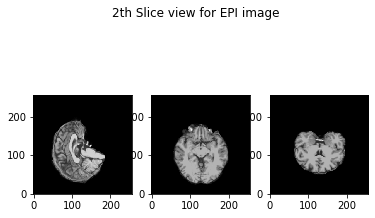

In [61]:
samp1 = SliceViewer(np.load(reg_samples[0]))
samp1.triple_view()

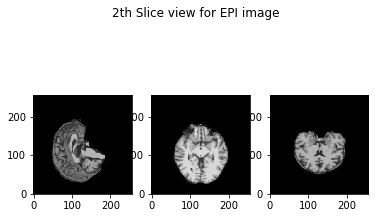

In [62]:
samp2 = SliceViewer(np.load(reg_samples[1]))
samp2.triple_view()

IXI560-Guys-1070-T1-brainmask_registered


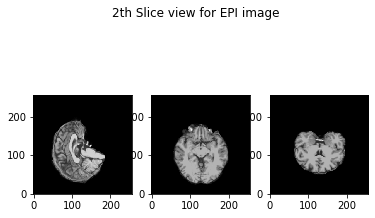

IXI210-Guys-0856-T1-brainmask_registered


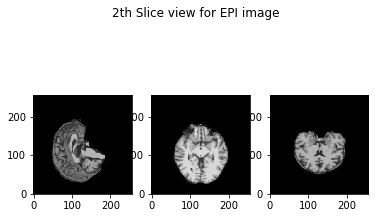

IXI587-Guys-1128-T1-brainmask_registered


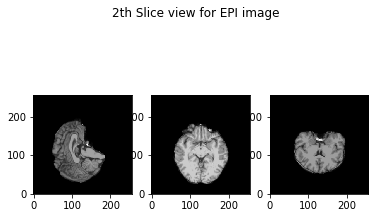

IXI181-Guys-0790-T1-brainmask_registered


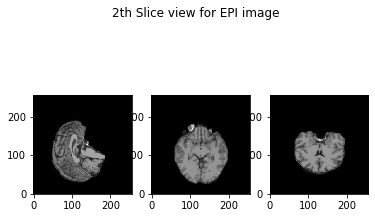

IXI298-Guys-0861-T1-brainmask_registered


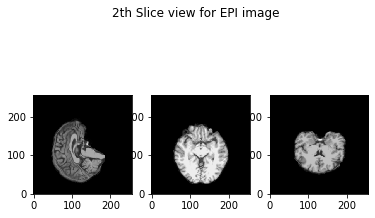

IXI247-Guys-0838-T1-brainmask_registered


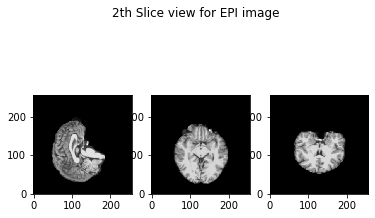

IXI512-Guys-1054-T1-brainmask_registered


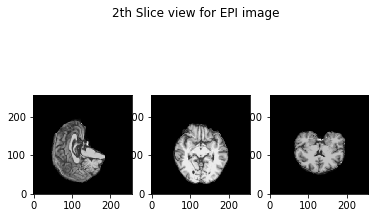

IXI321-Guys-0903-T1-brainmask_registered


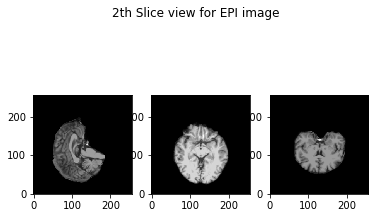

IXI227-Guys-0813-T1-brainmask_registered


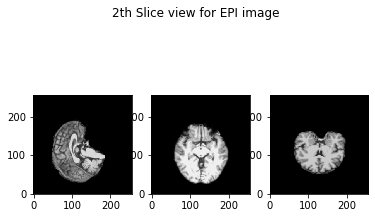

IXI107-Guys-0761-T1-brainmask_registered


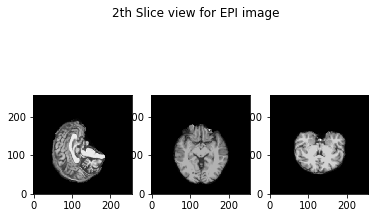

In [63]:
for samp in reg_samples:
    
    print(samp.split('\\')[-1].split('.')[0])
    SliceViewer(np.load(samp)).triple_view()